# NLP Case Study: Classifying and Summarizing Patient-Doctor Dialogues

Let's explore two core tasks in natural language processing: classification and summarization. We'll be using the [MTS-Dialog](https://github.com/abachaa/MTS-Dialog) dataset from the EACL 2023 paper: [An Empirical Study of Clinical Note Generation from Doctor-Patient Encounters](https://aclanthology.org/2023.eacl-main.168/). This dataset contains 1,700 transcripts of patient-doctor conversations for training and fine-tuning models. We'll begin by exploring and pre-processing the raw data, then implementing different models and evaluating their performance qualitatively and quantitatively on various performance metrics. Let's proceed with the initial exploratory data analysis and see what we're working with. 

## Exploratory Data Analysis

This dataset is easy to wrap our heads around because it's small - only 1700 rows by 4 columns. It will easily fit into memory, so we can load it into a `pandas.DataFrame` and begin exploring.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./MTS-Dialog/Main-Dataset/MTS-Dialog-TrainingSet.csv', index_col="ID")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1200
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   section_header  1201 non-null   object
 1   section_text    1201 non-null   object
 2   dialogue        1201 non-null   object
dtypes: object(3)
memory usage: 37.5+ KB


The training set has 1200 rows and the rest are saved for testing. The `dialogue` column is a string with raw back-and-forth conversation between patient and doctor, `section_text` is a summarization of it, and `section_header` is a classification of it according to about a dozen fixed categories. We can see the first few rows:

In [50]:
df.head()

section_header                                       section_text  \
ID                                                                     
0           GENHX  The patient is a 76-year-old white female who ...   
1           GENHX  The patient is a 25-year-old right-handed Cauc...   
2           GENHX  This is a 22-year-old female, who presented to...   
3     MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4              CC                                   Burn, right arm.   

                                             dialogue  
ID                                                     
0   Doctor: What brings you back into the clinic t...  
1   Doctor: How're you feeling today?  \r\nPatient...  
2   Doctor: Hello, miss. What is the reason for yo...  
3   Doctor: Are you taking any over the counter me...  
4   Doctor: Hi, how are you? \r\nPatient: I burned...

The names `section_text` and `section_header` aren't intuitive, so let's rename them.

In [51]:
df.rename(
    columns={
        "section_text": "summary",
        "section_header": "category"
    }, 
    inplace=True
)

An easy graph to make is a histogram demonstrating the frequency of the categories the dialogues have been marked in the training set.

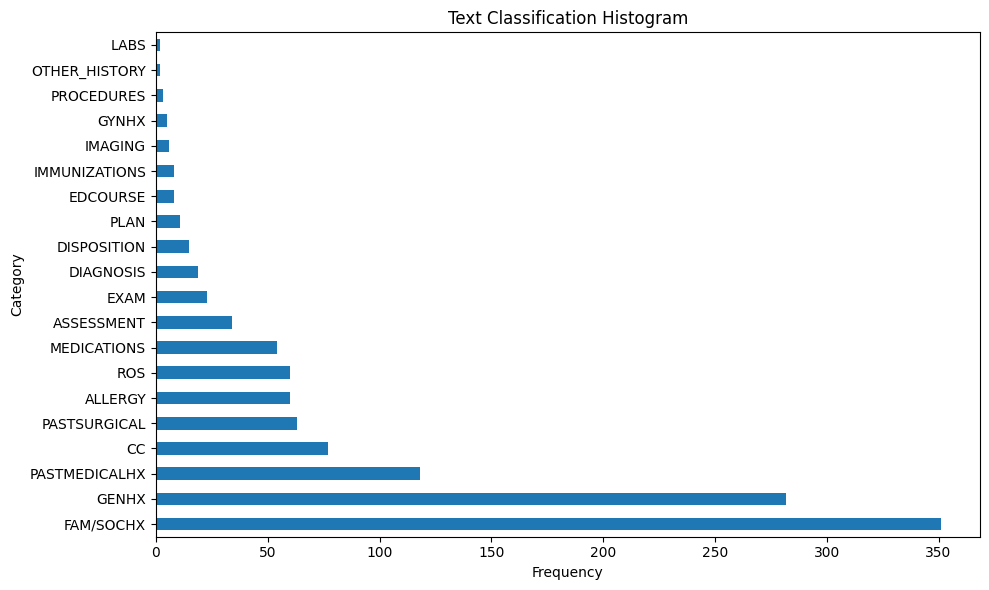

In [52]:
# Adjusting figure size for better readability
plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed

df['category'].value_counts().plot(kind='barh')

plt.title('Text Classification Histogram')
plt.ylabel('Category')
plt.xlabel('Frequency')
plt.tight_layout()  # Automatically adjusts subplot params to give specified padding
plt.show()

Some of these abbreviations aren't obvious, but it's easy to interpret them if we need. 

In [57]:
def interpret_category(text):
    table = {
        'FAM/SOCHX': 'FAMILY HISTORY/SOCIAL HISTORY',
        'GENHX': 'HISTORY of PRESENT ILLNESS',
        'PASTMEDICALHX': 'PAST MEDICAL HISTORY',
        'CC': 'CHIEF COMPLAINT',
        'PASTSURGICAL': 'PAST SURGICAL HISTORY',
        'ROS': 'REVIEW OF SYSTEMS',
        'EDCOURSE': 'EMERGENCY DEPARTMENT COURSE',
        'GYNHX': 'GYNECOLOGIC HISTORY'
    }
    text = text.strip().upper()
    text = table.get(text, text)
    return text

It's hard to summarize this data with statistics or graphs because it's all natural language conversations. Also, the data is already clean and reliable, so standard cleaning techniques like dropping null values or casting column types aren't needed. Let's look at some dialogue examples and see if anything else jumps out.

In [6]:
df['dialogue'].head()

0    Doctor: What brings you back into the clinic t...
1    Doctor: How're you feeling today?  \r\nPatient...
2    Doctor: Hello, miss. What is the reason for yo...
3    Doctor: Are you taking any over the counter me...
4    Doctor: Hi, how are you? \r\nPatient: I burned...
Name: dialogue, dtype: object

The values are just raw strings with characters like `\n` indicating new lines, so Python's `print()` function will format them correctly.

In [7]:
print(df['dialogue'].iloc[0])

Doctor: What brings you back into the clinic today, miss? 
Patient: I came in for a refill of my blood pressure medicine. 
Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?  
Patient: No. 
Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?
Patient: No.  
Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as?
Patient: I am seventy six years old and identify as a white female.


Let's see how the dataset would expect us to summarize this dialogue for its key takeaways.

In [8]:
print(df['summary'].iloc[0])

The patient is a 76-year-old white female who presents to the clinic today originally for hypertension and a med check.  She has a history of hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Since her last visit she has been followed by Dr. Kumar.  Those issues are stable.  She has had no fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure.


And finally, let's see the category to which it would belong.

In [9]:
print(interpret_header(df['category'].iloc[0]))

HISTORY of PRESENT ILLNESS


As you'd expect, patient-doctor dialogues are typically structured like a Q&A so a summarization model will need to understand who is speaking and how to put that in context. Let's look at some pre-processing techniques we can perform to help it learn from this unique kind of dataset.

## Text Preprocessing

Preprocessing is a step common to all machine learning workflows that involves making deliberate adjustments and transformations to the data so it's easier for the model to consume or interpret. While data cleaning can be mechanical and rules-based, pre-processing often involves some research judgment. Common steps such as tokenization, removing stopwords, stemming, and more are taken depending on the specific requirements of your task.

For this dataset, here are some options we could consider:
1. Speaker Tag Removal: Remove speaker tags like "Doctor:" and "Patient:" to focus on the content of the dialogue. However, consider retaining this information in a structured form if the distinction between doctor and patient speech is relevant to the summary.
2. Sentence Segmentation: Segment the text into individual sentences to better understand the structure of the conversation and to assist the model in identifying key pieces of information.
3. Lowercasing: Convert the entire text to lowercase to maintain consistency and avoid the model treating the same words differently due to case differences.
4. Punctuation and Special Characters Removal: Remove unnecessary punctuation and special characters that do not contribute to the meaning of the text. However, be cautious with periods as they can denote sentence boundaries.
5. Stop Words Removal: Remove common words (stop words) that appear frequently in the English language but often don't contribute much meaning to the specific context (e.g., "the", "is", "in"). This step is optional and should be considered carefully, as stop words can sometimes carry important information in certain contexts.
6. Lemmatization: Reduce words to their base or root form (lemma) to consolidate different forms of the same word, thus reducing the model's complexity.
7. Handling Medical Terminology: Medical transcripts contain specialized terminology that may not be well-represented in pre-trained models' vocabularies. Consider using medical NLP tools or custom dictionaries to map complex medical terms to more general terms understood by the model, or ensure the model is fine-tuned on a dataset that includes such terminology.
8. Entity Recognition and Normalization: Identify and normalize entities such as medication names, conditions, and measurements. This could involve mapping synonyms to a standard term and ensuring consistency across the dataset.
9. Handling Numbers and Units: Convert numbers and units into a consistent format, especially for age, measurements, and dosages, which are critical in medical summaries.
10. Contextual Embeddings: For advanced pre-processing, consider generating contextual embeddings for sentences or phrases that capture the semantic meaning, which can be particularly useful for summarization tasks in specialized domains like healthcare.
11. Data Augmentation: To improve model robustness, consider augmenting your dataset by paraphrasing sentences or generating synthetic dialogues based on the existing ones, ensuring a diverse range of expressions and terms.

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Example input
text = """
Doctor: What brings you back into the clinic today, miss? 
Patient: I came in for a refill of my blood pressure medicine. 
Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?  
Patient: No. 
Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?
Patient: No.  
Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as?
Patient: I am seventy six years old and identify as a white female.
"""

def preprocess_text(text):
    # Remove speaker tags
    text = re.sub(r'(Doctor|Patient):\s', '', text)

    # Sentence segmentation
    sentences = sent_tokenize(text)

    # Initialize lemmatizer and stop words list
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    processed_sentences = []
    for sentence in sentences:
        # Lowercasing
        sentence = sentence.lower()
        # Remove punctuation
        sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
        # Tokenization
        words = word_tokenize(sentence)
        # Remove stop words and lemmatize
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_sentences.append(' '.join(words))

    # Rejoin processed sentences
    processed_text = ' '.join(processed_sentences)
    return processed_text

processed_text = preprocess_text(text)

This code snippet includes basic pre-processing steps such as speaker tag removal, lowercasing, punctuation removal, and lemmatization. Depending on your specific requirements and the characteristics of your dataset, you may choose to implement additional steps mentioned above.

Let's see the results:

In [11]:
# Original
print(text)


Doctor: What brings you back into the clinic today, miss? 
Patient: I came in for a refill of my blood pressure medicine. 
Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?  
Patient: No. 
Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?
Patient: No.  
Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as?
Patient: I am seventy six years old and identify as a white female.



In [12]:
# Processed
print(processed_text)

brings back clinic today miss came refill blood pressure medicine look like doctor kumar followed last time regarding hypertension osteoarthritis osteoporosis hypothyroidism allergic rhinitis kidney stone noticed change concern regarding issue  fever chill cough congestion nausea vomiting chest pain chest pressure  great also record old race identify seventy six year old identify white female


The processed text is obviously less readable to humans, but you'll notice the most important information is still there. Look at all the things you can still understand from it:
* The reason for the visit: `came refill blood pressure medicine`
* Existing conditions: `last time regarding hypertension osteoarthritis osteoporosis hypothyroidism allergic rhinitis kidney stone`
* Patient identity: `old race identify seventy six year old identify white female`

The only tricky part is this:
```
noticed change concern regarding issue  fever chill cough congestion nausea vomiting chest pain chest pressure
```
In the original dialogue, we know the doctor is asking the patient if she has been experiencing any of these symptoms and she says no. In the processed version, it's could look like the patient is telling the doctor that she "noticed a change and is concerned regarding issues..." and so on. We made the choice to drop the patient/doctor labels from the text, and that introduced ambiguity here. However, with the other 3 cases it was fine so long as the order of the words stays the same overall. We'll see if it ultimately helps or worsens our model's performance later down the line.

Let's go ahead an apply the `preprocess_text()` function to the entire dialogue column in the DataFrame.

In [62]:
df['dialogue_preprocessed'] = df['dialogue'].apply(preprocess_text)

df['dialogue_preprocessed'].head()

ID
0    brings back clinic today miss came refill bloo...
1    howre feeling today terrible im worst headache...
2    hello miss reason visit today think wart back ...
3    taking counter medicine one prescribed alterna...
4       hi burned hand oh sorry wow yeah right arm yes
Name: dialogue_preprocessed, dtype: object

## Text Classification

Our first goal is to train a model to match dialogues to their categories. This is easier than summarization because text classification can be done with simple regression models that have been used for decades. The key trick here is converting the raw text into a vector embedding that captures the same spatial information but can be fed into a numerical model like a logistic regression.

### tf-idf (term frequency-inverse document frequency)

TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a statistical measure used to evaluate the importance of a word to a document in a collection or corpus. It's particularly useful in text classification tasks. 

* Term Frequency (TF): This measures how frequently a term occurs in a document. The more often a term appears, the higher its weight.
* Inverse Document Frequency (IDF): This measures the importance of the term across a set of documents. If a term appears in many documents, it's considered less important and gets a lower weight.

TF-IDF helps in mitigating the effect of the most common words in the dataset, which might not be useful for classification. It highlights words that are distinctive and could be more predictive.

TF-IDF is used to convert textual data into a vector space model, where each document is represented by a vector. Each dimension of the vector corresponds to a specific term in your dataset's vocabulary, and the value in each dimension is the TF-IDF score of the term in that particular document. This transformation is crucial because machine learning algorithms work with numerical data, not text. TF-IDF effectively translates text into a numerical form that algorithms can process.

Considerations: 
* Dimensionality: TF-IDF can result in high-dimensional feature vectors, especially with large vocabularies. Dimensionality reduction techniques or feature selection might be necessary.
* Tuning: The performance of your model can depend on how you configure the TF-IDF transformation (e.g., n-gram range, max features, etc.).

### Approach #1: Traditional Classification Models

Using TF-IDF, we can test out some traditional classifiers and evaluate their performance. Using `sklearn`, let's take some out-of-the-box models and apply them here.

#### Naive Bayes

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

training_set = df

# Sample data
texts = training_set['dialogue']
texts_preprocessed = training_set['dialogue_preprocessed']
labels = training_set['category'] # Corresponding labels

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2)
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(texts_preprocessed, labels, test_size=0.2)

# Creating a TF-IDF Vectorizer and Classifier Pipeline
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model
model.fit(X_train, y_train)

# Predicting and Evaluating the model
print("NaiveBayes - Raw Text\n")
predicted_labels = model.predict(X_test)
print(classification_report(y_test, predicted_labels, zero_division=0))
print()

model.fit(X_train_pre, y_train_pre)

print("NaiveBayes - Preprocessed Text\n")
predicted_labels = model.predict(X_test_pre)
print(classification_report(y_test_pre, predicted_labels, zero_division=0))

NaiveBayes - Raw Text

               precision    recall  f1-score   support

      ALLERGY       0.00      0.00      0.00        12
   ASSESSMENT       0.00      0.00      0.00         3
           CC       0.00      0.00      0.00        11
    DIAGNOSIS       0.00      0.00      0.00         2
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         2
         EXAM       0.00      0.00      0.00         8
    FAM/SOCHX       0.68      0.93      0.78        76
        GENHX       0.41      0.97      0.58        58
        GYNHX       0.00      0.00      0.00         3
      IMAGING       0.00      0.00      0.00         2
IMMUNIZATIONS       0.00      0.00      0.00         2
  MEDICATIONS       0.00      0.00      0.00        11
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.00      0.00      0.00        24
 PASTSURGICAL       0.00      0.00      0.00        12
         PLAN       0.00      0.00      0

For a classifier, the terms precision, recall, f1-score, and support are key metrics used to evaluate its performance, particularly in the context of classification tasks. Each term provides different insights into how well the classifier is performing:

**Precision:** measures the accuracy of the positive predictions made by the classifier. It is defined as the ratio of true positive predictions to the total number of positive predictions (which includes both true positives and false positives).
   - Mathematically, it's expressed as: Precision = True Positives (TP) / ( True Positives (TP) + False Positives (FP) )
   - High precision indicates that the classifier has a low false positive rate, meaning that when it predicts a class, it is very likely correct.

**Recall** (Sensitivity): measures the ability of the classifier to find all the positive samples. It is the ratio of true positive predictions to the total number of actual positives (which includes both true positives and false negatives).
   - It's expressed as: Recall = True Positives (TP) / (True Positives (TP) + False Negatives (FN)) 
   - High recall indicates that the classifier is good at capturing a high proportion of actual positives.

**F1-Score:** The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both. It's particularly useful when you want to balance precision and recall, and there's an uneven class distribution (large number of actual negatives). 
   - It's calculated as: F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
   - The F1-score ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 indicates the worst.

**Support:** refers to the number of actual occurrences of the class in the specified dataset. For each class label, it tells you how many instances of the class were present in the dataset that was used to evaluate the classifier. It's important for understanding the size of the sample for each class which can be critical for evaluating the performance metrics, especially in imbalanced datasets where one class might significantly outnumber the others.

### Support Vector Machines

To extend the code to use Support Vector Machines (SVMs) instead of Naive Bayes for classification, you'll need to make a few adjustments. The key change is to replace the MultinomialNB classifier with an SVM classifier from Scikit-Learn, such as SVC (Support Vector Classifier).

In [80]:
from sklearn.svm import SVC  # Importing Support Vector Classifier
model = make_pipeline(TfidfVectorizer(), SVC())
# Training the model
model.fit(X_train, y_train)

# Predicting and Evaluating the model
print("SVM - Raw Text\n")
predicted_labels = model.predict(X_test)
print(classification_report(y_test, predicted_labels, zero_division=0))
print()

model.fit(X_train_pre, y_train_pre)

print("SVM - Preprocessed Text\n")
predicted_labels = model.predict(X_test_pre)
print(classification_report(y_test_pre, predicted_labels, zero_division=0))

SVM - Raw Text

               precision    recall  f1-score   support

      ALLERGY       1.00      0.92      0.96        12
   ASSESSMENT       0.00      0.00      0.00         3
           CC       0.00      0.00      0.00        11
    DIAGNOSIS       0.00      0.00      0.00         2
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         2
         EXAM       0.00      0.00      0.00         8
    FAM/SOCHX       0.72      0.95      0.82        76
        GENHX       0.62      0.97      0.76        58
        GYNHX       0.00      0.00      0.00         3
      IMAGING       0.00      0.00      0.00         2
IMMUNIZATIONS       0.00      0.00      0.00         2
  MEDICATIONS       1.00      0.73      0.84        11
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.71      0.50      0.59        24
 PASTSURGICAL       0.90      0.75      0.82        12
         PLAN       0.00      0.00      0.00    

Considerations:
* Classifier Replacement: The MultinomialNB is replaced with SVC from sklearn.svm. SVC is a more powerful classifier than Naive Bayes and can handle non-linear relationships in the data.
* Parameter Tuning: SVMs have several hyperparameters like C, kernel, and gamma that can significantly influence the performance. You might want to experiment with these to find the best combination for your specific dataset.
* Scaling: While not explicitly shown in the code, SVMs typically benefit from feature scaling. However, in the case of TF-IDF vectors, feature scaling might not be necessary as TF-IDF naturally results in normalized vectors.
* Computational Resources: SVMs can be computationally more intensive than Naive Bayes, especially on large datasets or with certain kernel choices (like 'rbf'). Keep this in mind regarding performance and runtime.

By using SVMs, you're likely to achieve better performance, especially on complex datasets, as SVMs are effective in finding the optimal boundary between different classes. However, the choice between Naive Bayes and SVM should be guided by the nature of your data and the specific requirements of your task.

### Random Forests

A Random Forest classifier constructs multiple decision trees during training and outputs the mode of the classes predicted by individual trees for classification tasks. It starts by creating different subsets of the original dataset through bootstrap sampling, where each subset can contain repeated instances of data points. This process, known as bagging, helps in reducing overfitting by decreasing the variance of the model without increasing the bias.

In addition to bagging, Random Forest introduces randomness in the selection of features when building each tree. At each node of a tree, instead of considering all features for the best split, a random subset of features is chosen. This approach ensures that the trees in the forest are de-correlated, making the ensemble model more robust and accurate than individual decision trees.

The final prediction of the Random Forest is determined by aggregating the predictions from all trees. For classification, this typically involves taking a majority vote among the predictions made by individual trees. This ensemble method combines the predictions to improve accuracy and handle higher dimensional data effectively, making Random Forest a versatile and powerful classifier that balances bias and variance well.

In [81]:
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest Classifier
# Creating a TF-IDF Vectorizer and Classifier Pipeline
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Training the model
model.fit(X_train, y_train)

print("Random Forests - Raw Text\n")
predicted_labels = model.predict(X_test)
print(classification_report(y_test, predicted_labels, zero_division=0))
print()

model.fit(X_train_pre, y_train_pre)

print("Random Forests - Preprocessed Text\n")
predicted_labels = model.predict(X_test_pre)
print(classification_report(y_test_pre, predicted_labels, zero_division=0))

Random Forests - Raw Text

               precision    recall  f1-score   support

      ALLERGY       0.86      1.00      0.92        12
   ASSESSMENT       0.00      0.00      0.00         3
           CC       0.00      0.00      0.00        11
    DIAGNOSIS       0.00      0.00      0.00         2
  DISPOSITION       0.00      0.00      0.00         2
     EDCOURSE       0.00      0.00      0.00         2
         EXAM       1.00      0.12      0.22         8
    FAM/SOCHX       0.65      0.95      0.77        76
        GENHX       0.72      0.95      0.82        58
        GYNHX       0.00      0.00      0.00         3
      IMAGING       0.00      0.00      0.00         2
IMMUNIZATIONS       0.00      0.00      0.00         2
  MEDICATIONS       0.88      0.64      0.74        11
OTHER_HISTORY       0.00      0.00      0.00         1
PASTMEDICALHX       0.78      0.29      0.42        24
 PASTSURGICAL       0.77      0.83      0.80        12
         PLAN       0.00      0.00   

## Takeaways

The simplest way to compare the 3 models above are by weighted precision, recall, and f1-score, so preliminary research shows the Random Forest model performs the best, with SVMs being a close second. Some categories of conversation have few examples (<10) in the training data and the model fails to learn them at all, which isn't surprising. However, the most frequent categories like FAM/SOCHX and GENHX consistently get decent metrics on their samples. Interestingly, some categories with a relatively small amount of samples also show high scores, such as MEDICATIONS and PASTSURGICAL. It's hard to say for certain, but one explanation for this is the TF-IDF vectorizer we use to represent the text in the beginning - words associated with medications or surgical procedures are likely to appear in the specific document frequently but not in others, giving them a high signal according to TF-IDF.

Text preprocessing seems to benefit performance slightly on Random Forests, but detract from the performance of SVMs (according to weighted averages). The next steps are to test the model on the out-of-sample test dataset and perform additional hyperparameter tuning to get final evaluation metrics. Lastly, there are many other models, preprocessing techniques, and word embeddings that can be used to achieve the same result, and finding the best combination is a process of trial-and-error, experimentation, and research intuition. 

## Text Summarization

Text summarization presents a unique and challenging task for AI models due to the complexity of natural language and the nuanced understanding required to distill lengthy texts into concise summaries. This task involves not just reducing the length of the text but also capturing its core essence, which requires a deep understanding of language semantics, context, and the ability to discern the most relevant information.

One of the main challenges in text summarization is the inherent ambiguity and variability of natural language. Words and sentences can have multiple meanings depending on their context, and different parts of a text can have varying degrees of importance. AI models need to navigate these subtleties to determine what information is crucial and should be included in the summary. This involves complex natural language processing (NLP) techniques and an understanding of linguistic structures, which can be difficult for AI to grasp fully.

Moreover, summarization requires not just extraction of important content but also synthesis, where the model may need to paraphrase or rephrase information to create a coherent and concise summary. This synthesis process demands a level of creativity and language generation capability that goes beyond simple extraction, making it a challenging task for AI. The model must maintain the original meaning and tone while ensuring the summary is readable and flows naturally, which is a sophisticated task requiring advanced NLP and deep learning techniques.

### Hugging Face's Transformers

[Hugging Face](https://huggingface.co/) is a French-American company based in New York City, known for developing tools for building applications using machine learning. It is particularly renowned for its `transformers` library, which is designed for natural language processing (NLP) applications. Hugging Face's platform allows users to share and collaborate on machine learning models and datasets, as well as showcase their work. This has made it a significant hub in the AI community, supporting a wide range of machine learning tasks, including text generation and image analysis.

> Note: The name "Hugging Face" is inspired by the emoji representing a smiling face giving a hug, known as the "hugging face" emoji (🤗). The choice of this name and symbol reflects the company's friendly and open approach to AI and its community-driven platform. The hugging face emoji symbolizes warmth, friendliness, and a sense of community, which aligns with the company's goal to democratize AI technology and make it accessible and collaborative. This playful and positive branding helps to make the field of AI more approachable and less intimidating, encouraging participation and innovation across diverse groups of people.

The Transformers library, developed by Hugging Face, is a comprehensive open-source library designed for natural language processing (NLP) and, more recently, for broader machine learning tasks. It has significantly influenced the field of AI by providing easy access to pre-trained models and the ability to fine-tune them for specific tasks. Here are some key points about the Transformers library:

1. **Pre-trained Models**: Transformers provides a vast collection of pre-trained models based on the transformer architecture, such as BERT, GPT, T5, and RoBERTa. These models have been trained on large datasets and can perform a wide range of NLP tasks, including text classification, question answering, text generation, and more.

2. **Architecture**: The library is named after the transformer architecture, introduced in the paper "[Attention is All You Need](https://arxiv.org/abs/1706.03762)" by Vaswani et al. This architecture is known for its self-attention mechanism, which allows models to weigh the importance of different words in a sentence, leading to significant improvements in understanding context and meaning.

3. **Ease of Use**: One of the library's main goals is to make state-of-the-art NLP models accessible to the broader AI community. It provides a simple and consistent API for using pre-trained models, fine-tuning them on custom datasets, and deploying models for various tasks.

4. **Language Support**: While initially focused on English, the library now includes models trained in multiple languages, offering multilingual capabilities and supporting NLP tasks in non-English languages.

5. **Community and Ecosystem**: Hugging Face has fostered a vibrant community around the Transformers library, where researchers, developers, and AI enthusiasts contribute models, training scripts, and datasets. This collaborative environment accelerates innovation and the adoption of new techniques in the field.

6. **Expansion Beyond NLP**: Although initially focused on NLP tasks, the library has expanded to include models for other domains such as computer vision and audio processing, making it a more general-purpose library for machine learning tasks.

7. **Integration and Compatibility**: The library is designed to be compatible with popular deep learning frameworks like TensorFlow and PyTorch, allowing users to integrate it seamlessly into their existing workflows and projects.

The Transformers library has become a cornerstone in the AI and NLP communities, enabling researchers and practitioners to achieve cutting-edge results with less effort and encouraging a more open and collaborative approach to AI research and development.

For this part of the notebook, we're going to leverage Transformers to perform text summarization on the patient-doctor dialogues. To get started, install the Python library in your active virtual environment:

```bash
pip install 'transformers[torch]'
```

You can verify your installation with this command:

```bash
python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"
```
If it's working correctly, you should see an output like this:
```bash
[{'label': 'POSITIVE', 'score': 0.9998704195022583}]
```

## Applying Transformers to Patient-Doctor Conversations

With everything installed, let's use it on the dataset we have and examine its performance. 

It's important to understand the distinction between the `Transformers` library and the actual AI model that we'll use to summarize text. As mentioned, the HuggingFace website hosts hundreds of pre-trained models that anyone can download and use for the tasks they were trained. If we go to the [models section of the website and filter down to text summarization](https://huggingface.co/models?pipeline_tag=summarization&sort=trending), it looks something like this:

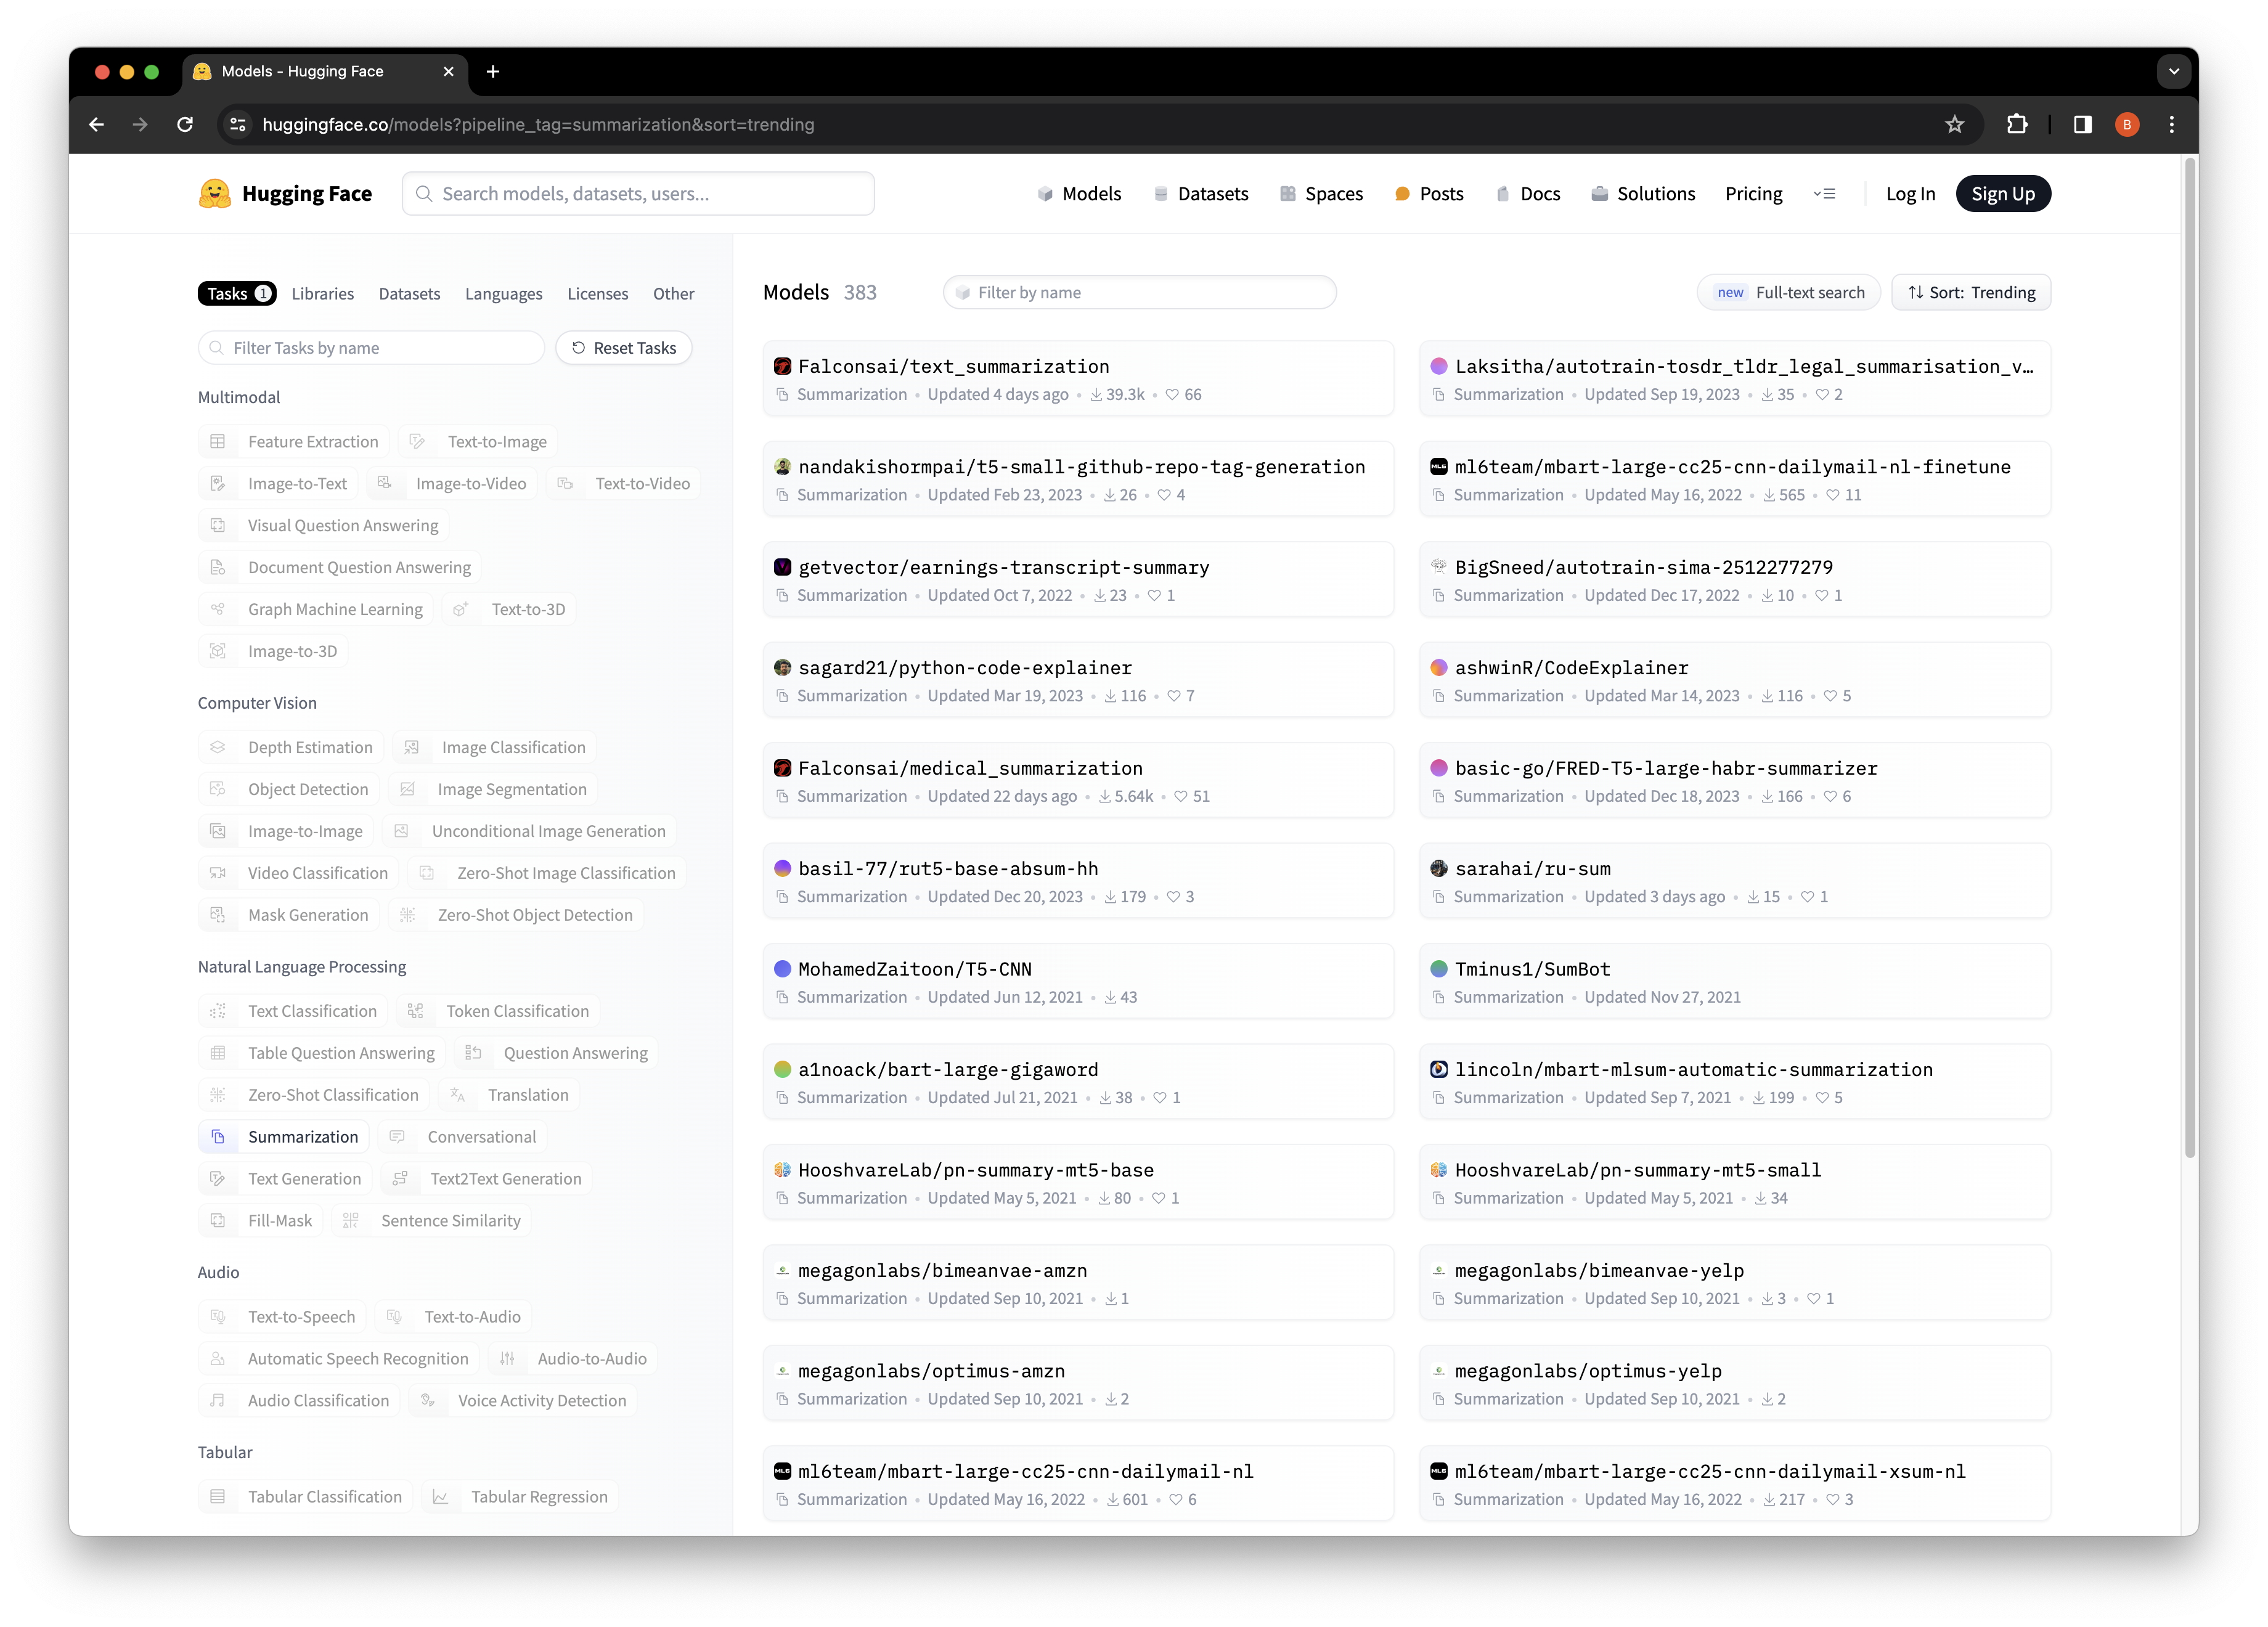

Each item you see here consists of the architecture, parameters, and weights of a specific AI model. In contrast, the `Transformers` library just provides the Python infrastructure to load, tune, and execute these models. Once we begin coding, you'll see the `Transformers` library operates in terms of "pipelines" because it provides a pipeline where data can flow from your computer into a model and back out again. 

I'm making this point now because it highlights the first problem we must address: which model(s) do we choose? We usually take the following approach:
1. Sort by trending or identify well-known architectures for the task you are performing.
2. Pick 3-5 models that seem relevant. 
3. Evaluate them all and identify the best one.
4. Fine-tune the best one for better performance on your specific dataset (if possible).

> Note: To the lament of many purists and theoreticians, progress in the field of AI has largely been driven by empirical observations and trial-and-error experimentation. While creative ideas in architecture and computation techniques have brought breakthroughs, there's nothing wrong with following the rough process of trying different things out, tweaking them a bit, and picking the best one.

### Model Selection

I'm going to look at 2 models here:

#### [Falconsai/medical_summarization](https://huggingface.co/Falconsai/medical_summarization)

> The T5 Large for Medical Text Summarization is a specialized variant of the T5 transformer model, fine-tuned for the task of summarizing medical text. This model is designed to generate concise and coherent summaries of medical documents, research papers, clinical notes, and other healthcare-related text.
> The T5 Large model, known as "t5-large," is pre-trained on a broad range of medical literature, enabling it to capture intricate medical terminology, extract crucial information, and produce meaningful summaries. The fine-tuning process for this model is meticulous, with attention to hyperparameter settings, including batch size and learning rate, to ensure optimal performance in the field of medical text summarization.

Looks promising!

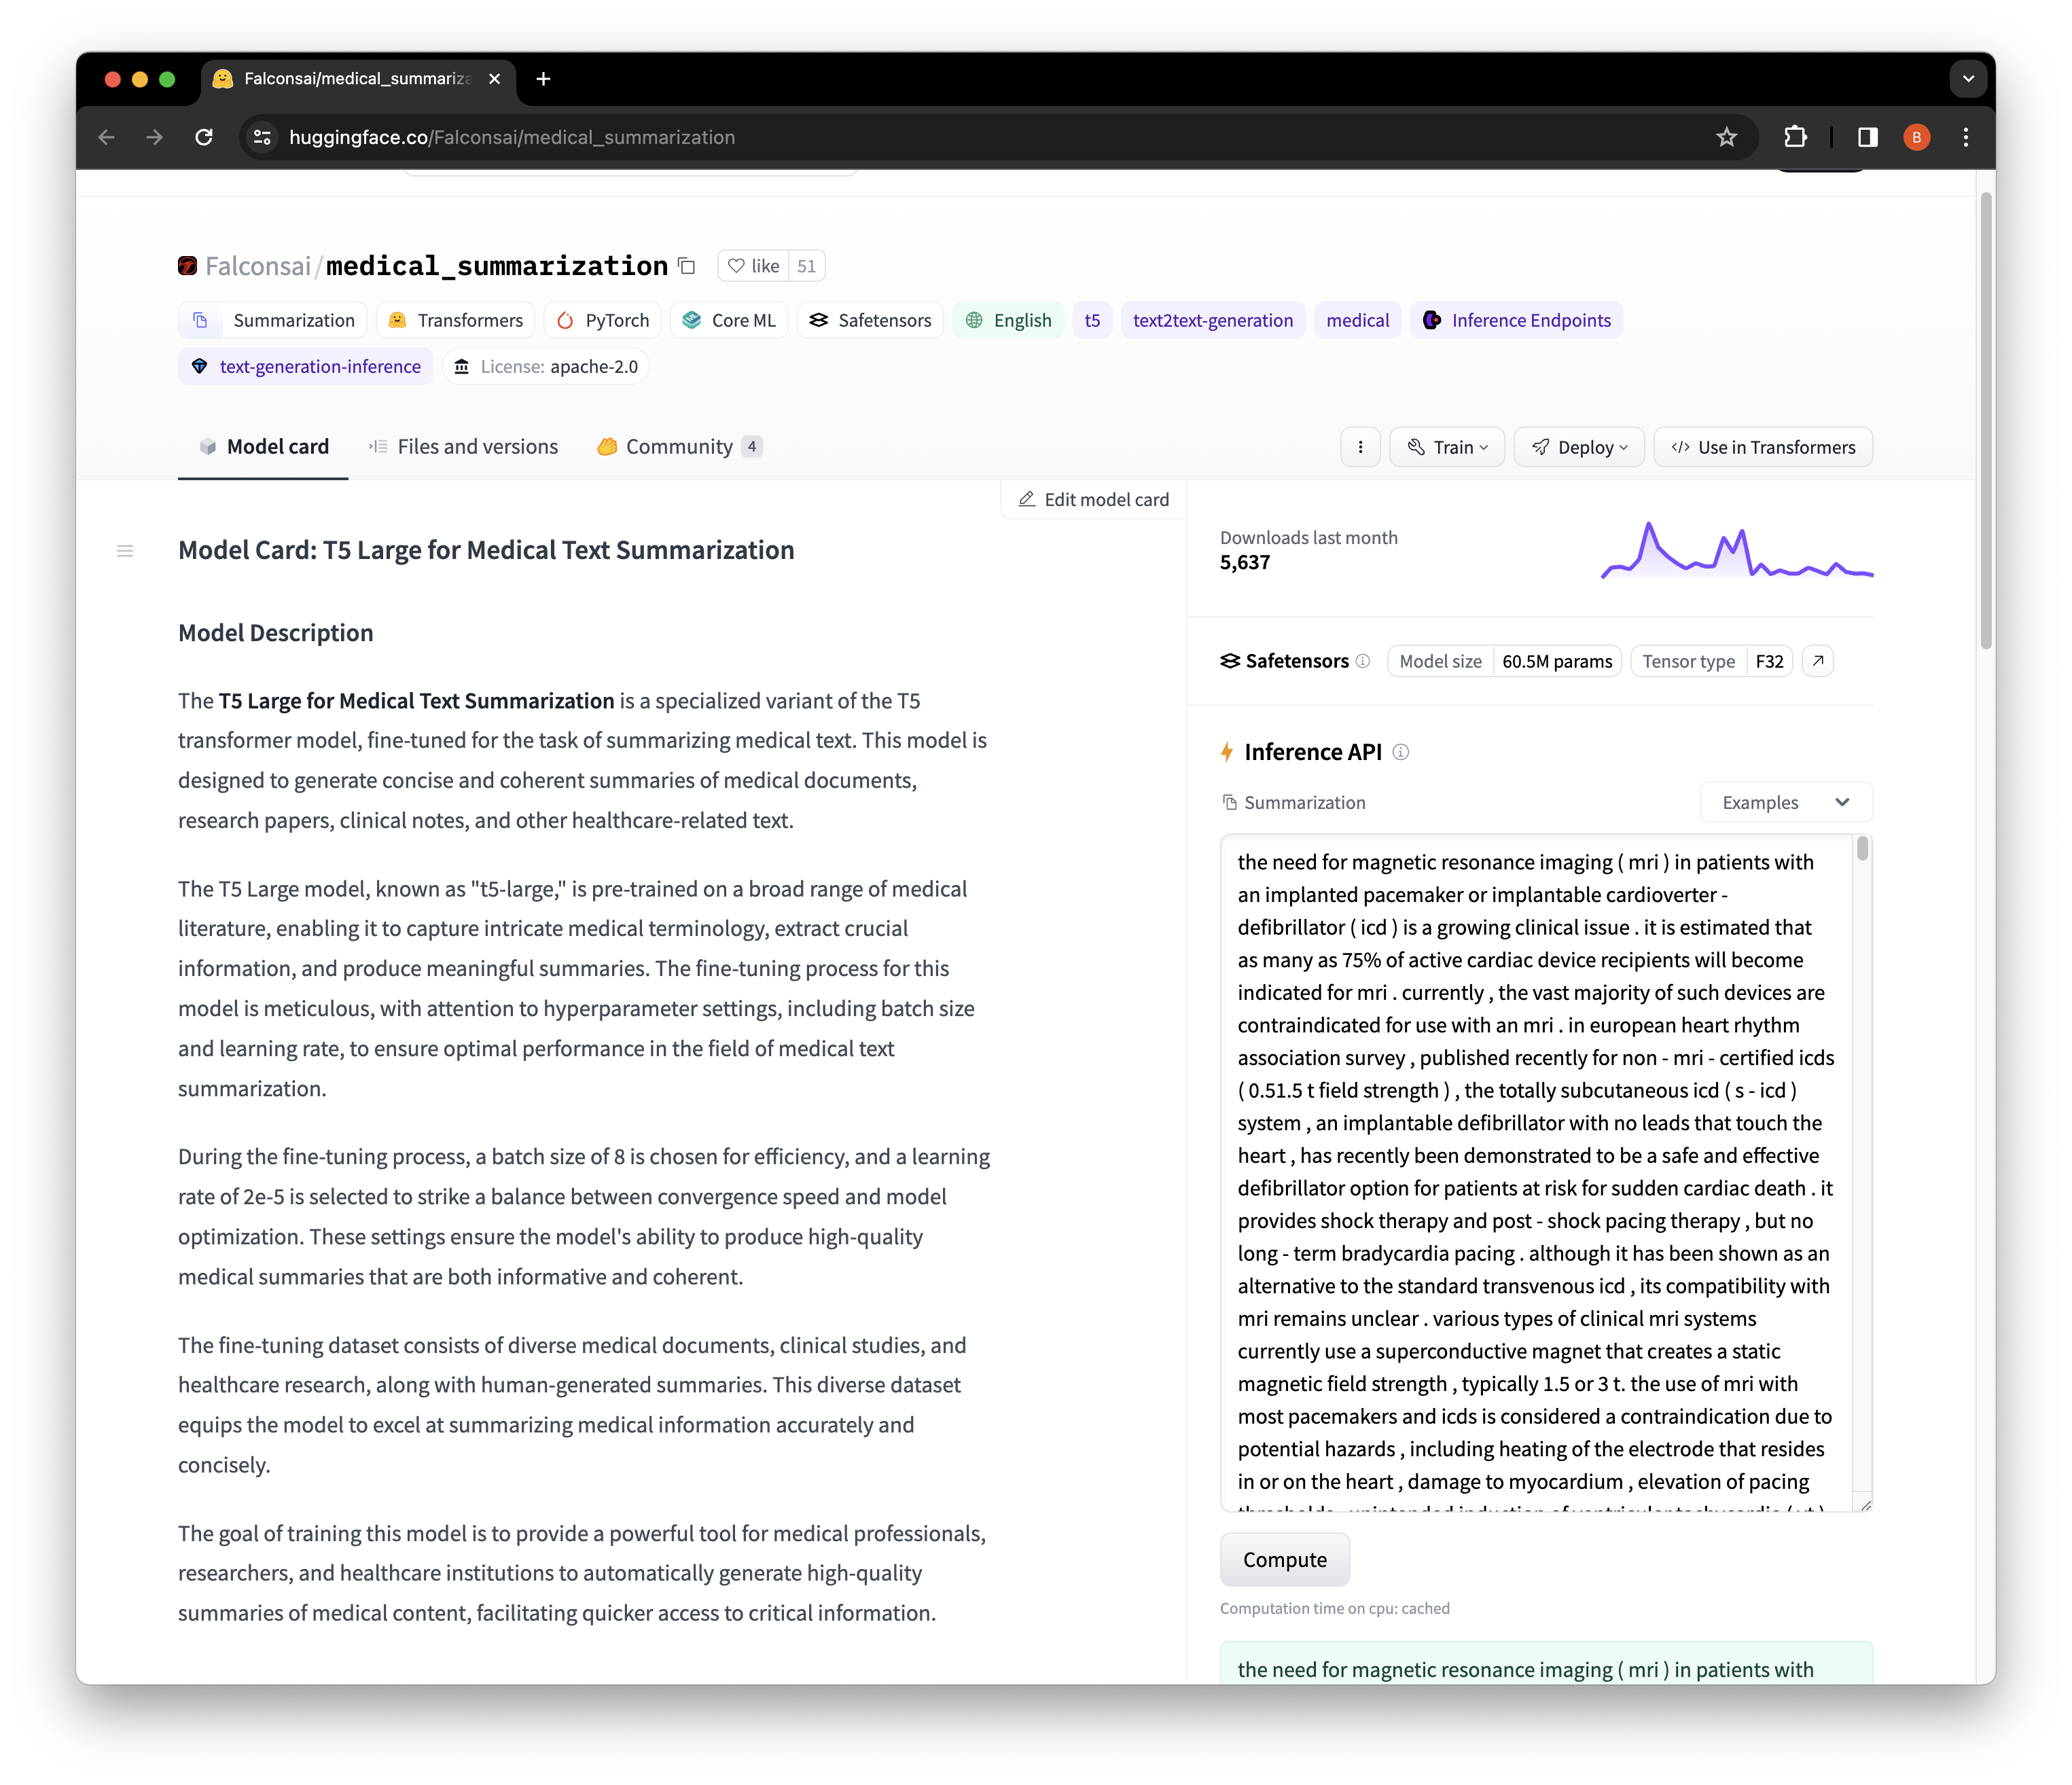

#### [Falsonsai/text_summarization](https://huggingface.co/Falconsai/text_summarization)

> The Fine-Tuned T5 Small is a variant of the T5 transformer model, designed for the task of text summarization. It is adapted and fine-tuned to generate concise and coherent summaries of input text.
> The model, named "t5-small," is pre-trained on a diverse corpus of text data, enabling it to capture essential information and generate meaningful summaries. Fine-tuning is conducted with careful attention to hyperparameter settings, including batch size and learning rate, to ensure optimal performance for text summarization.

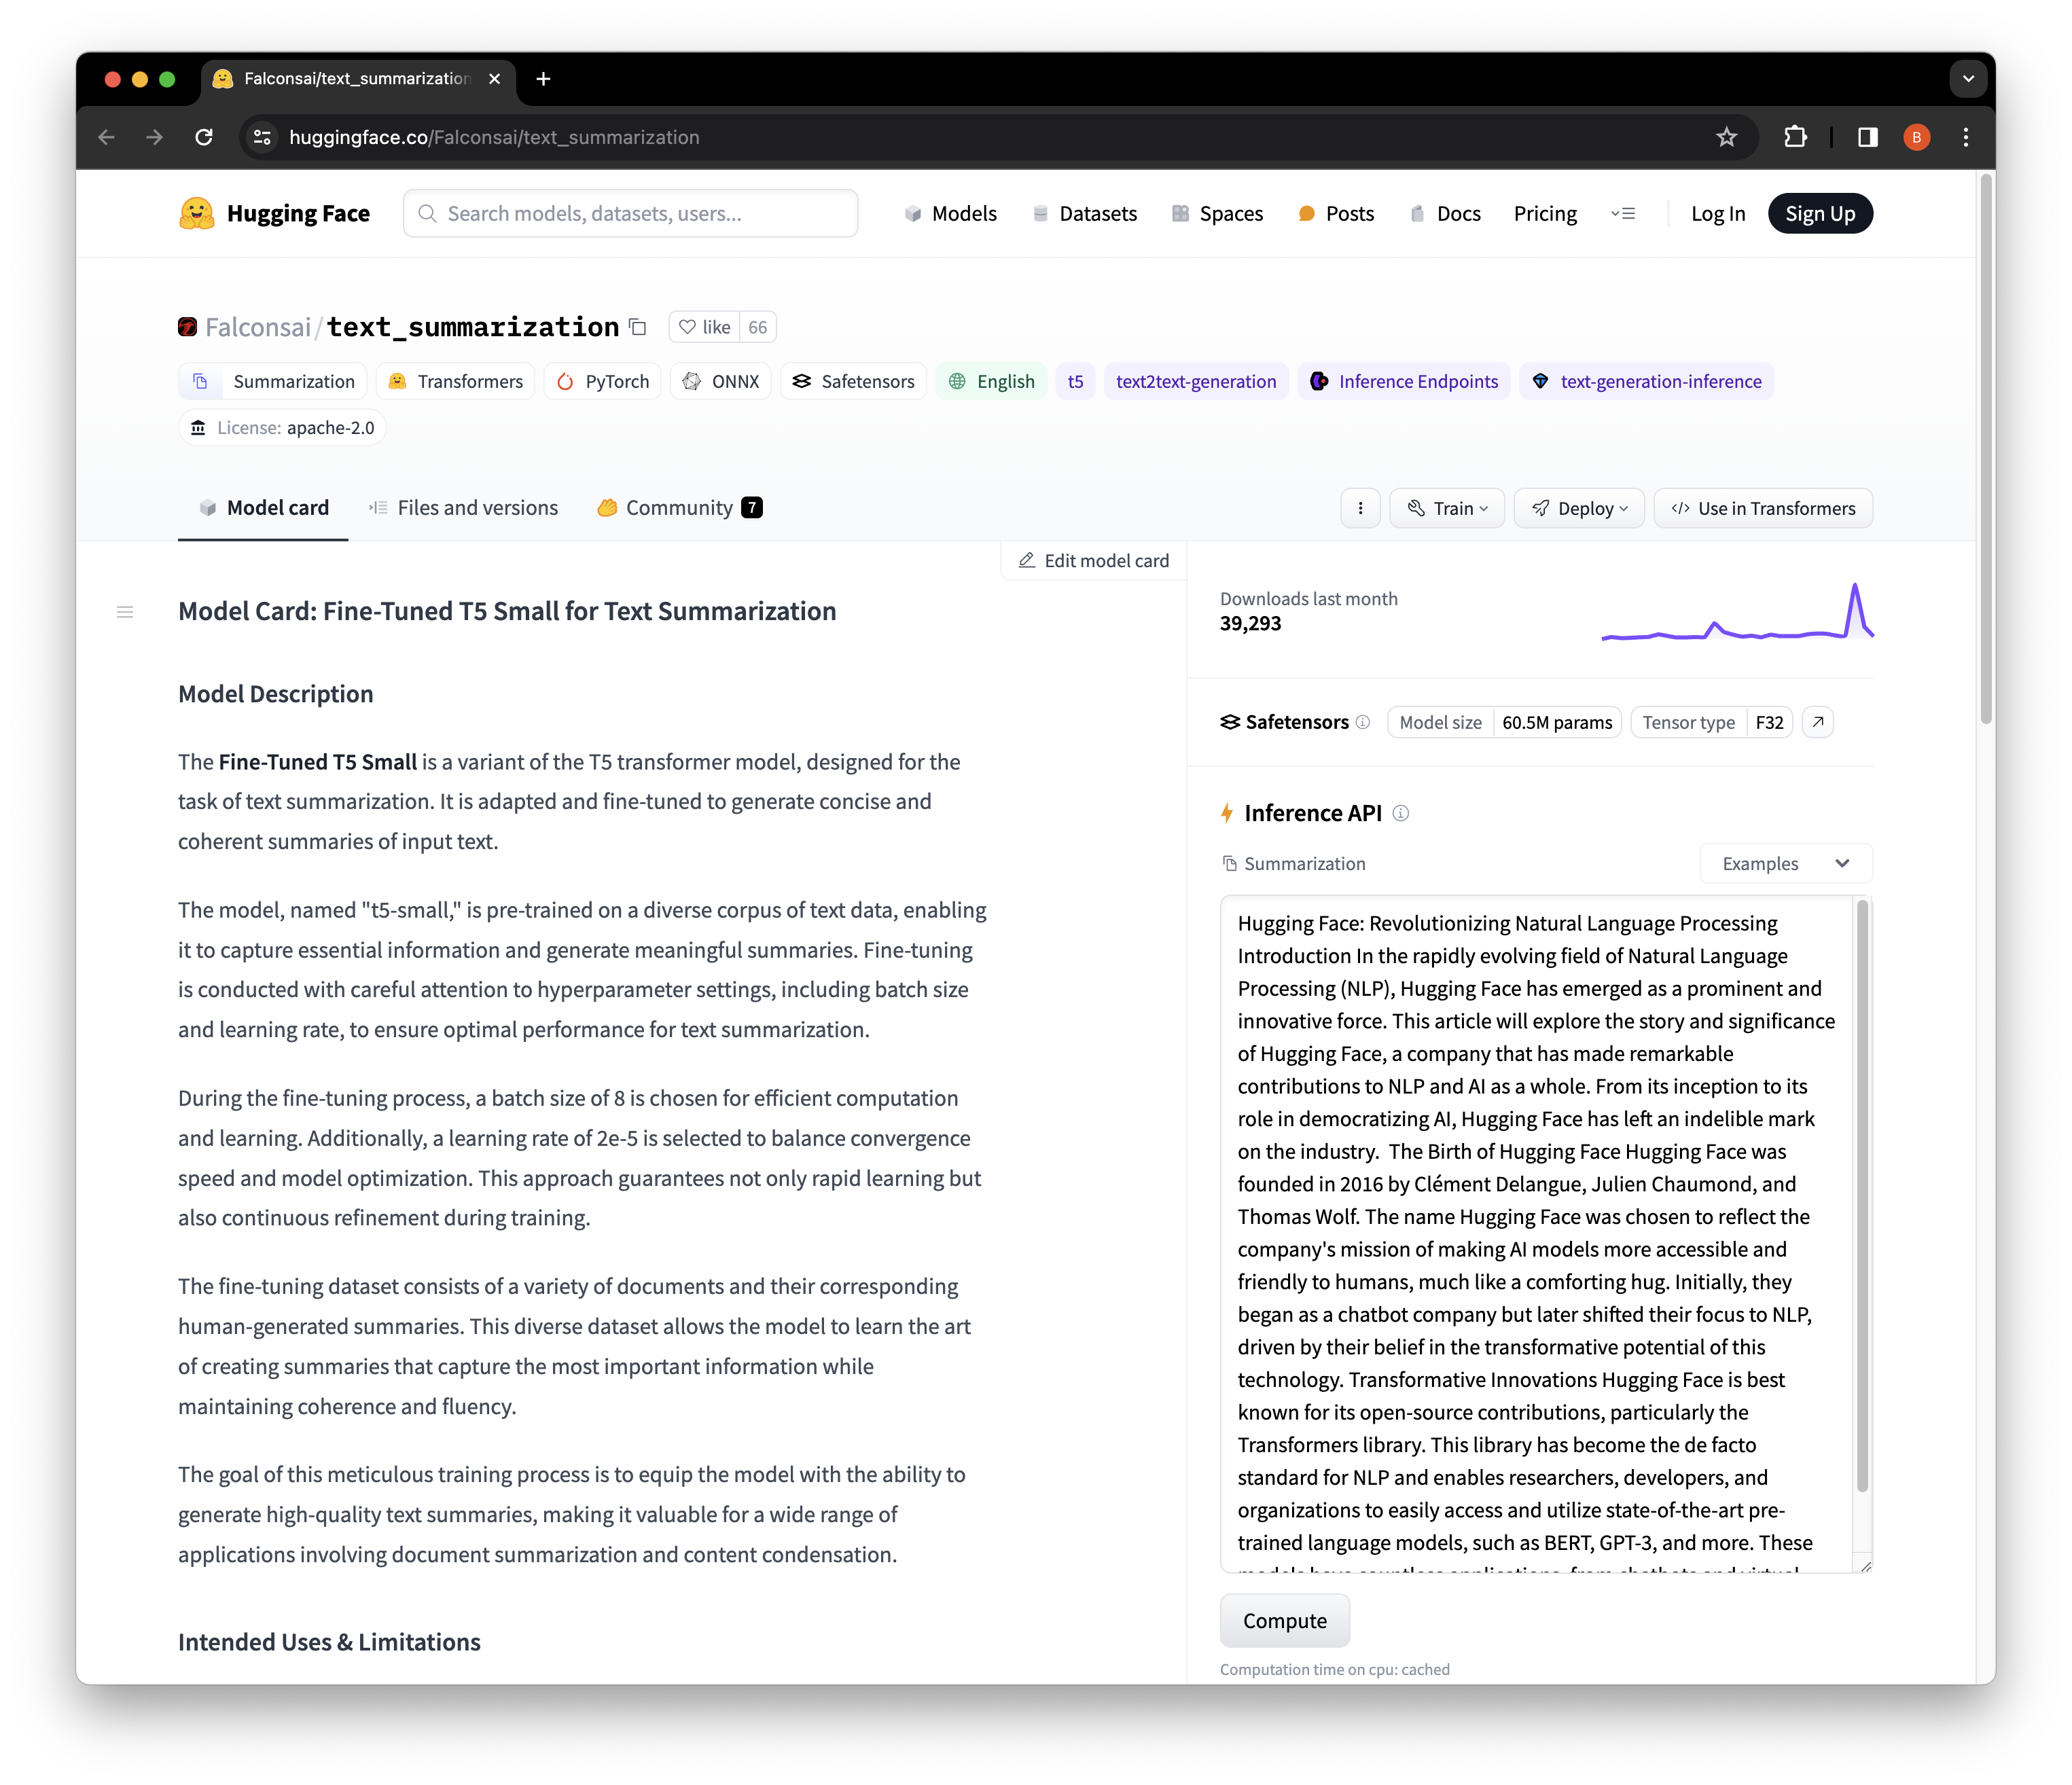

This is a more general-purpose text summarization model, so it will be interesting how it compares to the specialized one.

### Defining a Pipeline

In [82]:
# Use a pipeline as a high-level helper
from transformers import pipeline

summarizer = pipeline("summarization", model="Falconsai/medical_summarization")

Recall the dataset:

In [83]:
df.head()

category                                            summary  \
ID                                                                   
0         GENHX  The patient is a 76-year-old white female who ...   
1         GENHX  The patient is a 25-year-old right-handed Cauc...   
2         GENHX  This is a 22-year-old female, who presented to...   
3   MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4            CC                                   Burn, right arm.   

                                             dialogue  \
ID                                                      
0   Doctor: What brings you back into the clinic t...   
1   Doctor: How're you feeling today?  \r\nPatient...   
2   Doctor: Hello, miss. What is the reason for yo...   
3   Doctor: Are you taking any over the counter me...   
4   Doctor: Hi, how are you? \r\nPatient: I burned...   

                                dialogue_preprocessed  
ID                                                     
0   brings back clinic today miss came refill bloo...  
1   howre feeling today terrible im worst headache...  
2   hello miss reason visit today think wart back ...  
3   taking counter medicine one prescribed alterna...  
4      hi burned hand oh sorry wow yeah right arm yes

We'll apply this model to both the `dialogue` and `dialogue_preprocessed` column. 

In [89]:
import datetime 

summaries = []

start = datetime.datetime.now()

for d in df['dialogue']:
    max_length = len(d.split(' '))
    min_length = min(10, max_length)
    s = summarizer(d, max_length=max_length, min_length=min_length)
    s = s[0]['summary_text']
    summaries.append(s)

end = datetime.datetime.now()

runtime = end - start
print(f"Runtime: {runtime}")

Runtime: 0:34:40.562457


In [93]:
summaries_preprocessed = []

start = datetime.datetime.now()

for d in df['dialogue_preprocessed']:
    max_length = len(d.split(' '))
    min_length = min(10, max_length)
    s = summarizer(d, max_length=max_length, min_length=min_length)
    s = s[0]['summary_text']
    summaries_preprocessed.append(s)

end = datetime.datetime.now()

runtime = end - start
print(f"Runtime: {runtime}")

Runtime: 0:21:33.521116


In [99]:
df['dialogue_summaries_medicalsummarization'] = summaries
df['dialogue_preprocessed_summaries_medicalsummarization'] = summaries_preprocessed

In [98]:
def compare_by_row(idx):
    r = df.iloc[idx]
    print('ORIGINAL\n'+100*'-')
    print(r['dialogue'])
    print('\nPREPROCESSED\n'+100*'-')
    print(r['dialogue_preprocessed'])
    print('\nSUMMARIZED\n'+100*'-')
    print(r['dialogue_summaries_medicalsummarization'])
    print('\nPREPROCESSED SUMMARIZED\n'+100*'-')
    print(r['dialogue_preprocessed_summaries_medicalsummarization'])
 
compare_by_row(0)

ORIGINAL
----------------------------------------------------------------------------------------------------
Doctor: What brings you back into the clinic today, miss? 
Patient: I came in for a refill of my blood pressure medicine. 
Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?  
Patient: No. 
Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?
Patient: No.  
Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as?
Patient: I am seventy six years old and identify as a white female.

PREPROCESSED
----------------------------------------------------------------------------------------------------
brings back clinic today miss came refill blood pressure medicine look like doctor kumar 

In [100]:
compare_by_row(1)

ORIGINAL
----------------------------------------------------------------------------------------------------
Doctor: How're you feeling today?  
Patient: Terrible. I'm having the worst headache of my life. 
Doctor: I'm so sorry. Well you are only twenty five, so let's hope this is the last of the worst. Let's see how we can best help you. When did it start? 
Patient: Around eleven in the morning. 
Doctor: Today? 
Patient: Um no yesterday. July thirty first. 
Doctor: July thirty first O eight. Got it. Did it come on suddenly? 
Patient: Yeah. 
Doctor: Are you having any symptoms with it, such as blurry vision, light sensitivity, dizziness, lightheadedness, or nausea? 
Patient: I'm having blurry vision and lightheadedness.  I also can't seem to write well. It looks so messy. I am naturally right handed but my writing looks like I am trying with my left. 
Doctor: How would you describe the lightheadedness? 
Patient: Like there are blind spots. 
Doctor: Okay. How about any vomiting? 
Patie

### Observations

The `medical_summarization` model is pretty brutal when taken right off the shelf. While it has some sense for which words are important, it extrapolates them in ways that are irrelevant and incorrect given the original dialogue. Additionally, it doesn't perform the summarization function as we'd intend it - while the results are shorter than the original dialogue, the information is not synthesized or formatted in an interpretable manner. Obviously, this model needs more fine tuning to improve it for the task at hand.

Let's try the more general `text_summarization` model next.

In [101]:
falconsai_text_summarizer = pipeline("summarization", model="Falconsai/text_summarization")

In [102]:
# This is the same code as before, but the `summarizer()` function is replaced with `falconsai_text_summarizer()`.
# It's better design to organize this in a re-usable function, but since this is just a research exploration it's 
# fine to copy-paste it around so we can iterate faster.

summaries = []

start = datetime.datetime.now()

for d in df['dialogue']:
    max_length = len(d.split(' '))
    min_length = min(10, max_length)
    s = falconsai_text_summarizer(d, max_length=max_length, min_length=min_length)
    s = s[0]['summary_text']
    summaries.append(s)

end = datetime.datetime.now()

runtime = end - start
print(f"Runtime: {runtime}")

Token indices sequence length is longer than the specified maximum sequence length for this model (813 > 512). Running this sequence through the model will result in indexing errors


Runtime: 0:28:53.213572


In [107]:
summaries_preprocessed = []

start = datetime.datetime.now()

for d in df['dialogue_preprocessed']:
    max_length = len(d.split(' '))
    min_length = min(10, max_length)
    s = falconsai_text_summarizer(d, max_length=max_length, min_length=min_length)
    s = s[0]['summary_text']
    summaries_preprocessed.append(s)

end = datetime.datetime.now()

runtime = end - start
print(f"Runtime: {runtime}")

Runtime: 0:21:42.296321


In [108]:
df['dialogue_summaries_textsummarization'] = summaries
df['dialogue_preprocessed_summaries_textsummarization'] = summaries_preprocessed

In [109]:
def compare_by_row(idx):
    r = df.iloc[idx]
    print('ORIGINAL\n'+100*'-')
    print(r['dialogue'])
    print('\nPREPROCESSED\n'+100*'-')
    print(r['dialogue_preprocessed'])
    print('\nSUMMARIZED\n'+100*'-')
    print(r['dialogue_summaries_textsummarization'])
    print('\nPREPROCESSED SUMMARIZED\n'+100*'-')
    print(r['dialogue_preprocessed_summaries_textsummarization'])
 
compare_by_row(0)

ORIGINAL
----------------------------------------------------------------------------------------------------
Doctor: What brings you back into the clinic today, miss? 
Patient: I came in for a refill of my blood pressure medicine. 
Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?  
Patient: No. 
Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure?
Patient: No.  
Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as?
Patient: I am seventy six years old and identify as a white female.

PREPROCESSED
----------------------------------------------------------------------------------------------------
brings back clinic today miss came refill blood pressure medicine look like doctor kumar 

In [110]:
compare_by_row(1)

ORIGINAL
----------------------------------------------------------------------------------------------------
Doctor: How're you feeling today?  
Patient: Terrible. I'm having the worst headache of my life. 
Doctor: I'm so sorry. Well you are only twenty five, so let's hope this is the last of the worst. Let's see how we can best help you. When did it start? 
Patient: Around eleven in the morning. 
Doctor: Today? 
Patient: Um no yesterday. July thirty first. 
Doctor: July thirty first O eight. Got it. Did it come on suddenly? 
Patient: Yeah. 
Doctor: Are you having any symptoms with it, such as blurry vision, light sensitivity, dizziness, lightheadedness, or nausea? 
Patient: I'm having blurry vision and lightheadedness.  I also can't seem to write well. It looks so messy. I am naturally right handed but my writing looks like I am trying with my left. 
Doctor: How would you describe the lightheadedness? 
Patient: Like there are blind spots. 
Doctor: Okay. How about any vomiting? 
Patie

### Observations

This model doesn't perform great out-of-the-box either, but surprisingly it does seem a little better than the `medical_summarization` one. Arguably, it understands the purpose of the summarization task better while the other model overindexed heavily on the medical terminology on which it was trained. Neither model really achieved passable performance on the dataset examples though, which goes to show that open source, off-the-shelf models really aren't perfect. We could likely achieve better performance by fine-tuning the model on the dataset itself, or by using a *larger* proprietary model like GPT-4 from OpenAI, which can be accessed directly from their API. While this wouldn't be any sort of ground breaking research, it would get the job done and show how powerful general purpose models like GPT-4 are on specialized tasks. 

## References
* Asma Ben Abacha, Wen-wai Yim, Yadan Fan, and Thomas Lin. "An Empirical Study of Clinical Note Generation from Doctor-Patient Encounters." In *Proceedings of the 17th Conference of the European Chapter of the Association for Computational Linguistics*, pages 2291–2302, Dubrovnik, Croatia, May 2023. Association for Computational Linguistics. [URL](https://aclanthology.org/2023.eacl-main.168)
* Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). *Attention Is All You Need*. arXiv:1706.03762 [cs.CL]. https://arxiv.org/abs/1706.03762